In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r'C:\Users\Josh\Documents\Data Science\GradSchoolAdmissions\Admission_predict.csv')

Let's see what we're working with...

In [2]:
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


The idea here is to apply a machine learning algorithm to try and get a prediction of probability of admittance for any given combination of these factors.

I will first try a simple linear regression model, and then compare it to a more advanced random forest regressor and see how the two match up.  I suspect the random forest regressor will definitely outperform the simple linear regression!

First I'll clean the data up.

In [3]:
data.drop('Serial No.', axis='columns', inplace=True)

In [4]:
data.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

Now for some visualization.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


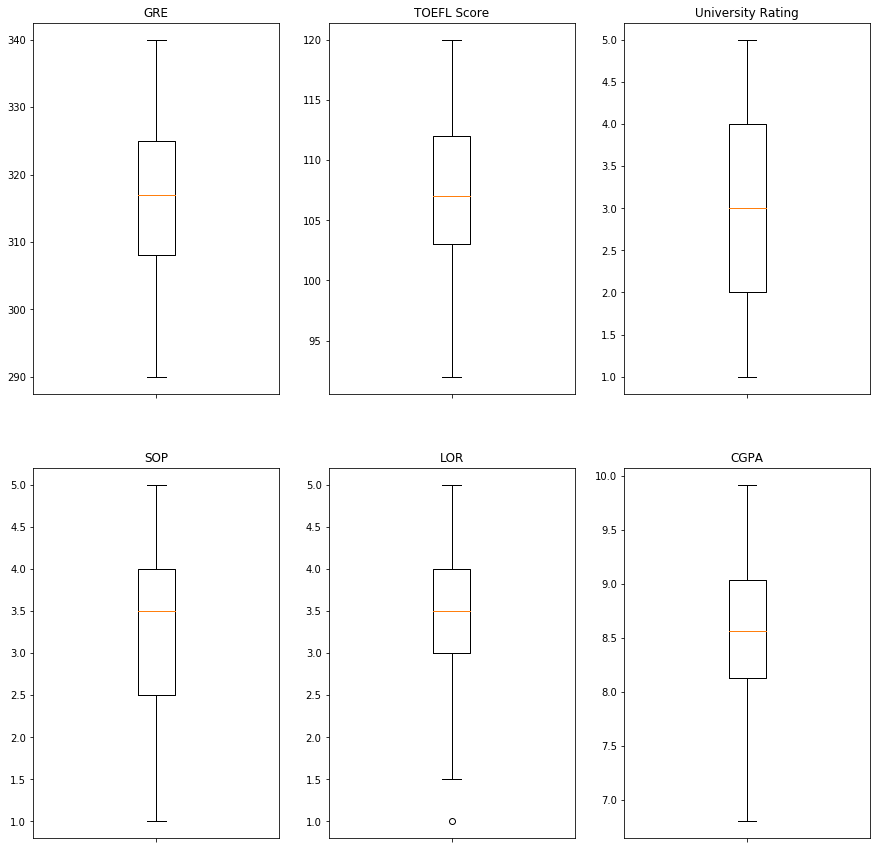

In [5]:
numFeatures = ['GRE Score', 'TOEFL Score','University Rating','SOP', 'LOR','CGPA']
fig, axs = plt.subplots(2,3, figsize=(15,15))
axs[0,0].boxplot(data['GRE Score'])
axs[0,0].set_title('GRE')
axs[0,1].boxplot(data['TOEFL Score'])
axs[0,1].set_title('TOEFL Score')
axs[0,2].boxplot(data['University Rating'])
axs[0,2].set_title('University Rating')
axs[1,0].boxplot(data['SOP'])
axs[1,0].set_title('SOP')
axs[1,1].boxplot(data['LOR'])
axs[1,1].set_title('LOR')
axs[1,2].boxplot(data['CGPA'])
axs[1,2].set_title('CGPA')
for ax in axs.flat:
    ax.set_xticklabels('')
# fig.tick_params(axis='x',         which='both',      bottom=False,      top=False,         labelbottom=False)
fig.show()

All of these factors have a large range of values, however the main thing that catches my interest is how much the innerquartile range varies between them. Note, I didn't include Chance of Admit in this boxplot analysis because I'd imagine intuitively that the proportion of admittance chance is inversely proportional to their percentile in it.  IE the information is self describing and doesn't need a plot.

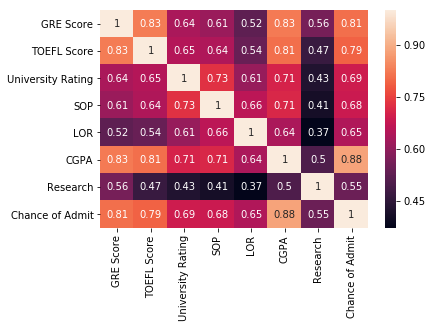

In [6]:
sns.heatmap(data.corr(), annot=True)

Looking at the correlation map, it seems like GPA has the biggest effect on acceptance rate, followed by GRE score and TOEFL.  This data set comes from India so it makes sense why TOEFL would have such an effect on acceptance.

Now I'm going to create some models to see what kind of preditive accuracy I can get off of this data.

In [7]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
encodedData = data
le = LabelEncoder()
encodedData['Research'] = le.fit_transform(encodedData['Research'])

x = encodedData.drop('Chance of Admit', axis='columns')
y = encodedData['Chance of Admit']

train_x, val_x, train_y, val_y = train_test_split(x,y, random_state=1)
model = LinearRegression(normalize=True)
model.fit(train_x,train_y)
val_predictions = model.predict(val_x)
print(model.score(val_x,val_y))

0.8127980254458259


Not bad, basic linear regression got an R^2 of .81.  This is actually a pretty solid model, but let's see what a logistic regression can do.

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
encodedData2 = data
encodedData2['Research'] = le.fit_transform(encodedData2['Research'])

x = encodedData2.drop('Chance of Admit', axis='columns')
y = encodedData2['Chance of Admit']

train_x, val_x, train_y, val_y = train_test_split(x,y, random_state=1)
model2 = RandomForestRegressor(random_state=1)
model2.fit(train_x,train_y)
val_predictions = model2.predict(val_x)
print(model2.score(val_x,val_y))

0.7607630948397783


C:\Users\Josh\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Hmm, so a random forest regressor actually performs worse than standard linear regression in this case.  What if I tweaked the parameters of the algorithm?

In [11]:
n = 10
leaf = 1
for i in range(1,4):
    for j in range(1,4):
        model = RandomForestRegressor(random_state=1, n_estimators=n**i,min_samples_leaf=leaf*j)
        model.fit(train_x,train_y)
        val_predictions = model.predict(val_x)
        print("Score with "+str(n**i)+" estimators and "+str(leaf*j)+" minimum samples per leaf: %f" % model.score(val_x,val_y))

# model3 = RandomForestRegressor(random_state=1, n_estimators=100,min_samples_leaf=50)
# model3.fit(train_x,train_y)
# val_predictions = model2.predict(val_x)
# print(model3.score(val_x,val_y))

# model4 = RandomForestRegressor(random_state=1, n_estimators=1000, min_samples_leaf=3)
# model4.fit(train_x,train_y)
# val_predictions = model4.predict(val_x)
# print(model4.score(val_x,val_y))

Score with 10 estimators and 1 minimum samples per leaf: 0.760763
Score with 10 estimators and 2 minimum samples per leaf: 0.751165
Score with 10 estimators and 3 minimum samples per leaf: 0.745672
Score with 100 estimators and 1 minimum samples per leaf: 0.768101
Score with 100 estimators and 2 minimum samples per leaf: 0.761418
Score with 100 estimators and 3 minimum samples per leaf: 0.758898
Score with 1000 estimators and 1 minimum samples per leaf: 0.765553
Score with 1000 estimators and 2 minimum samples per leaf: 0.761729
Score with 1000 estimators and 3 minimum samples per leaf: 0.762573


So tweaking the algorithm doesn't seem to change much in this case, however there are many parameters that can be changed and this only scratches the surface of the choices that can be made.

It is interesting to note, however, that with 10 estimators increasing the minimum samples per leaf actually decreases the R^2 but for any case above 10 estimatores, increasing the minimum samples per leaf increases the R^2.  I would like to delve more into the fundamentals of the algorithm to find out why exactly this is.

# Conclusion
In this analysis of grad school admissions rates, we saw that the single most important factor for determing success in getting into grad school is undergrad GPA, followed by GRE scores, and then by TOEFL scores.  Furthermore doing a regression on this data yields a better R^2 score than using a random forest regressor, which I am very surprised by.  I guess given the simple nature of the data linear regression has the advantage here (though it's important to point out that the advantage is pretty small).